# ENVI Tutorial on Spatial Pancreas data

### Pre-requisites

In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" # Change to -1 if you want to use CPU!

import warnings
warnings.filterwarnings('ignore')

In [3]:
import scenvi

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scanpy as sc
#import colorcet
import sklearn.neighbors
import scipy.sparse
import umap.umap_ as umap
#from fa2 import ForceAtlas2

In [4]:
!pip install squidpy

### Data

In [5]:
adata = sc.read('/lustre/groups/ml01/datasets/projects/20230301_Sander_SpatialPancreas_sara.jimenez/scrna/072424_npod_RNA_raw.h5ad')
adata_s1 = sc.read('/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/S1_ct_based_niche_label_npod_annotated.h5ad')

adata, adata_s1

(AnnData object with n_obs × n_vars = 276906 × 36601
     obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1', 'seurat_clusters', 'samples', 'sex', 'condition', 'RNA_snn_res.0.5', 'celltype_assignment1', 'SeuratClusters', 'celltype_assignment2', 'barcode', 'nPOD_barcode', 'CurrentObjLabels', 'nPOD_ID', 'technology', 'nCount_RAW_mtx', 'nFeature_RAW_mtx', 'conditionSubtype', 'CellTypes'
     var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
     obsm: 'X_harmony', 'X_pca', 'X_umap'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 108711 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_

### Subsetting and pre-processing

Filtering dissociated data

In [6]:
# Step 1: Calculate counts of CellTypes per nPOD_ID
celltype_counts = adata.obs.groupby(['nPOD_ID', 'CellTypes']).size().reset_index(name='counts')
# Step 2: Identify groups with fewer than 20 observations
filtered_counts = celltype_counts[celltype_counts['counts'] >= 20]
# Step 3: Keep only observations from filtered nPOD_ID and CellTypes combinations
valid_combinations = set(zip(filtered_counts['nPOD_ID'], filtered_counts['CellTypes']))
filtered_adata = adata[adata.obs.apply(lambda row: (row['nPOD_ID'], row['CellTypes']) in valid_combinations, axis=1)]
filtered_adata

View of AnnData object with n_obs × n_vars = 275215 × 36601
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1', 'seurat_clusters', 'samples', 'sex', 'condition', 'RNA_snn_res.0.5', 'celltype_assignment1', 'SeuratClusters', 'celltype_assignment2', 'barcode', 'nPOD_barcode', 'CurrentObjLabels', 'nPOD_ID', 'technology', 'nCount_RAW_mtx', 'nFeature_RAW_mtx', 'conditionSubtype', 'CellTypes'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'counts'

In [7]:
# Step 1: Calculate counts of each 'condition' per 'CellTypes'
condition_counts = filtered_adata.obs.groupby(['CellTypes', 'condition']).size().unstack(fill_value=0)

# Step 2: Identify 'CellTypes' that do not meet the specified criteria
# Criteria: 
# - Count of 'Aab' and 'Control' should be at least 2 each
# - Count of 'T1D' should be at least 2

invalid_celltypes = condition_counts[
    (condition_counts['Aab'] < 2) |
    (condition_counts['Control'] < 2) |
    (condition_counts['T1D'] < 2)
].index

# Step 3: Filter the AnnData object to remove invalid 'CellTypes'
adata_sc = filtered_adata[~filtered_adata.obs['CellTypes'].isin(invalid_celltypes)]
adata_sc

View of AnnData object with n_obs × n_vars = 274947 × 36601
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1', 'seurat_clusters', 'samples', 'sex', 'condition', 'RNA_snn_res.0.5', 'celltype_assignment1', 'SeuratClusters', 'celltype_assignment2', 'barcode', 'nPOD_barcode', 'CurrentObjLabels', 'nPOD_ID', 'technology', 'nCount_RAW_mtx', 'nFeature_RAW_mtx', 'conditionSubtype', 'CellTypes'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'counts'

In [8]:
sc.pp.highly_variable_genes(
    adata_sc,
    n_top_genes=5000,
    subset=True,
    #layer='counts',
)
adata_sc

AnnData object with n_obs × n_vars = 274947 × 5000
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1', 'seurat_clusters', 'samples', 'sex', 'condition', 'RNA_snn_res.0.5', 'celltype_assignment1', 'SeuratClusters', 'celltype_assignment2', 'barcode', 'nPOD_barcode', 'CurrentObjLabels', 'nPOD_ID', 'technology', 'nCount_RAW_mtx', 'nFeature_RAW_mtx', 'conditionSubtype', 'CellTypes'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'counts'

Checking cell type annotation such that labels are homogeneous in dissociated and spatial data

In [9]:
len(adata_sc.obs['CellTypes'].cat.categories)

14

In [10]:
len(adata_s1.obs['CellTypes_max'].cat.categories)

14

In [11]:
adata_sc.uns['CellTypes_colors'] = [
    '#4FB3AA',#'Acinar_basal'
    '#005F73',#'Acinar_highEnz', 
    '#0A9396',#'Acinar_sigdiff', 
    '#5FD3CF',#'Acinar_signal',
    '#e07a5f',#'Activated_Stellate', 
    '#b5838d',#'Alpha', 
    #'#f8ad9d',#'Bcells', 
    '#ffd6ff',#'Beta', 
    '#c8b6ff',#'Delta', 
    '#bde0fe',#'Ductal',
    '#f2cc8f',#'Endothelial', 
    #'#ffa62b',#'LymphEndo', 
    '#6096ba',#'MUC5b_Ductal', 
    '#8d0801',#'Macrophage', 
    #'#4f000b',#'Mast',
    '#ff7f51',#'Quiescent_Stellate', 
    #'#ce4257',#'Schwann', 
    '#e5383b',#'Tcells'
]

In [12]:
sc.pp.subsample(adata_sc,fraction=0.1)
adata_sc

AnnData object with n_obs × n_vars = 27494 × 5000
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1', 'seurat_clusters', 'samples', 'sex', 'condition', 'RNA_snn_res.0.5', 'celltype_assignment1', 'SeuratClusters', 'celltype_assignment2', 'barcode', 'nPOD_barcode', 'CurrentObjLabels', 'nPOD_ID', 'technology', 'nCount_RAW_mtx', 'nFeature_RAW_mtx', 'conditionSubtype', 'CellTypes'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'CellTypes_colors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'counts'

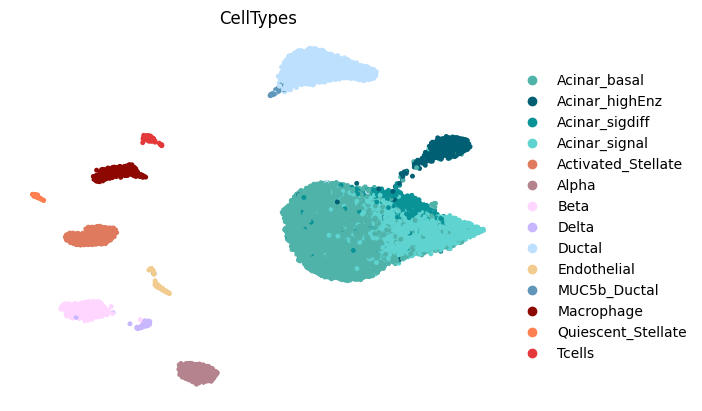

In [13]:
sc.pl.umap(adata_sc, color='CellTypes', frameon=False,size=50)

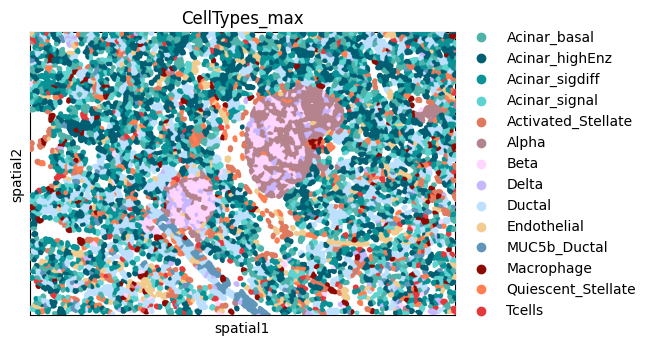

In [22]:
import squidpy as sq
sq.pl.spatial_segment(adata_s1,color=['CellTypes_max'],library_id=['12'],
                      library_key='fov', seg_cell_id='cell_ID', img=False)#,save='ct_fvo_19.pdf')

Subset to a field of view to test the mapping problem 

In [ ]:
sc.pp.pca(adata_sp_fov_12)
sc.pp.neighbors(adata_sp_fov_12)
sc.tl.umap(adata_sp_fov_12)
sc.tl.leiden(adata_sp_fov_12)

In [ ]:
import squidpy as sq
sq.pl.spatial_segment(adata_sp_fov_12,color=['cell_type','leiden'],
                      library_key='fov', seg_cell_id='cell_ID', img=False)

### Running ENVI

ENVI requires un-logged counts and it doesn't work with adata.X sparse 

In [14]:
st_data = adata_s1.copy()
st_data.X = st_data.layers['counts'].toarray()

sc_data = adata_sc.copy()
sc_data.X = adata_sc.layers['counts'].toarray()

print(sc_data.X.max())
print(st_data.X.max())

st_data, sc_data

3834.0
285


(AnnData object with n_obs × n_vars = 108711 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max', 'niche_label'
     uns: 'CellTypes_max_colors', 'cell_type_coarse_colors', 'design_matrix', 'neighbors', 'niche_label_colors', 'pca', 'spatial', 'spatial_neighbors', 'umap'
     obsm: 'X_pca', 'X_umap', 'design_matrix', 'spatial', 'spatial_fov'
     layers: 'counts'
     obsp: 'spatial_connectivities', 'spatial_distances',
 AnnData object wit

In [15]:
# the gene names in the spatial data must be contained in the dissociated data 
st_data = st_data[:,np.isin(st_data.var_names, sc_data.var_names)].copy()
st_data

AnnData object with n_obs × n_vars = 108711 × 427
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max', 'niche_label'
    uns: 'CellTypes_max_colors', 'cell_type_coarse_colors', 'design_matrix', 'neighbors', 'niche_label_colors', 'pca', 'spatial', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'design_matrix', 'spatial', 'spatial_fov'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [16]:
sc_data.obs['cell_type'] = sc_data.obs['CellTypes']
st_data.obs['cell_type'] = st_data.obs['CellTypes_max']

In [17]:
envi_model = scenvi.ENVI(spatial_data = st_data, sc_data = sc_data, batch_key='fov')

Computing Niche Covariance Matrices
Initializing VAE
Finished Initializing ENVI


In [18]:
envi_model.train()
envi_model.impute_genes()
envi_model.infer_niche_covet()
envi_model.infer_niche_celltype(cell_type_key='cell_type')

 spatial: -2.864e-01 sc: -1.109e-01 cov: -1.685e-03 kl: 5.247e-01: 100%|██████████| 16000/16000 [02:49<00:00, 94.63it/s] 


Finished imputing missing gene for spatial data! See 'imputation' in obsm of ENVI.spatial_data


In [19]:
st_data.obsm['envi_latent'] = envi_model.spatial_data.obsm['envi_latent']
st_data.obsm['COVET'] = envi_model.spatial_data.obsm['COVET']
st_data.obsm['COVET_SQRT'] = envi_model.spatial_data.obsm['COVET_SQRT']
st_data.uns['COVET_genes'] =  envi_model.CovGenes
st_data.obsm['imputation'] = envi_model.spatial_data.obsm['imputation']
st_data.obsm['cell_type_niche'] = envi_model.spatial_data.obsm['cell_type_niche']

sc_data.obsm['envi_latent'] = envi_model.sc_data.obsm['envi_latent']
sc_data.obsm['COVET'] = envi_model.sc_data.obsm['COVET']
sc_data.obsm['COVET_SQRT'] = envi_model.sc_data.obsm['COVET_SQRT']
sc_data.obsm['cell_type_niche'] = envi_model.sc_data.obsm['cell_type_niche']
sc_data.uns['COVET_genes'] =  envi_model.CovGenes

In [20]:
st_data.uns['COVET_genes']

array(['APOD', 'BAG3', 'C11orf96', 'C1QA', 'C1QB', 'CASR', 'CCL2',
       'CD163', 'CHGA', 'COL18A1', 'COL1A1', 'COL1A2', 'COL3A1', 'COL4A1',
       'COL4A2', 'COL6A1', 'COL6A2', 'COL6A3', 'COL9A3', 'CPB1', 'CXCL2',
       'CXCL3', 'DCN', 'FCGBP', 'FGFR3', 'FN1', 'FOS', 'G6PC2', 'GCG',
       'GDF15', 'GPX3', 'HLA-DRB1', 'HSPA1A', 'IAPP', 'IGHA1', 'IGKC',
       'IL7R', 'INS', 'JUNB', 'KRT19', 'KRT7', 'LEFTY1', 'LYZ', 'MALAT1',
       'MEG3', 'MMP7', 'OLFM4', 'PRSS2', 'S100A6', 'S100A8', 'SCG5',
       'SERPINA3', 'SPARCL1', 'SPINK1', 'SPP1', 'SST', 'THBS1', 'TIMP1',
       'TM4SF1', 'TPSAB1', 'TPSB2', 'TTR', 'VWF', 'ZFP36'], dtype='<U8')

### ENVI imputation on Spatial Data 

In [ ]:
markers = ['CPB1', 'INS', 'GCG', 'SPP1', 'CHGA', 'PECAM1', 'COL1A1', 'CD163']

In [ ]:
import anndata as ann# Create the anndata object
adata_imputed = ann.AnnData(st_data.obsm['imputation'])
adata_imputed.uns['spatial'] = adata_sp_fov_12.uns['spatial']
adata_imputed.obsm['spatial'] = adata_sp_fov_12.obsm['spatial']
adata_imputed.obs['fov'] = adata_sp_fov_12.obs['fov']
adata_imputed.obs['cell_ID'] = adata_sp_fov_12.obs['cell_ID']  
adata_imputed

In [ ]:
adata_imputed.var_names

In [ ]:
import squidpy as sq

In [ ]:
sq.pl.spatial_segment(adata_imputed,color=markers,ncols=3,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

In [ ]:
from scipy.stats import pearsonr

correlations_hallmark_genes = []

for i in markers:
    gene = i
    obs_genes = adata_sp_fov_12[:,[gene]].X.copy().toarray().flatten()
    imp_genes = adata_imputed[:,[gene]].X.copy().flatten()
    correlation, p_value = pearsonr(obs_genes, imp_genes)
    row_data = {
        'gene' : gene,
        'Pearson_correlation' : correlation,
        'P_value' : p_value
    }
    correlations_hallmark_genes.append(row_data)
                
df = pd.DataFrame(correlations_hallmark_genes)

In [ ]:
df

In [ ]:
df.to_csv('../corr_envi.csv', sep='\t', index=False)

In [ ]:
df['Pearson_correlation'].mean()

In [ ]:
sq.pl.spatial_segment(adata_imputed,color=['ARX','PAX6'],ncols=2,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

In [ ]:
markers

In [ ]:
adata_imputed.obs['cell_type'] = adata_sp_fov_12.obs['cell_type'] 
adata_imputed.uns['cell_type_colors'] = adata_sp_fov_12.uns['cell_type_colors']
#adata_imputed.layers['counts'] = adata_sp_fov_12.layers['counts']
adata_imputed

In [ ]:
adata_sp_fov_12,adata_imputed

In [ ]:
# Set global font sizes
plt.rcParams.update({
    'font.size': 12,            # Global font size
    'axes.titlesize': 16,       # Title font size
    'axes.labelsize': 14,       # Axis label font size
    'xtick.labelsize': 16,      # X-axis tick label font size
    'ytick.labelsize': 16,      # Y-axis tick label font size
    'legend.fontsize': 16,      # Legend font size
    'legend.title_fontsize': 16 # Legend title font size
})

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
fig, ax = plt.subplots(1, len(markers), figsize=(25, 6.8), sharey=True)

color = ['#edd892', #acinar
    '#adc178', #beta
    '#219ebc', #alpha
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac'] #Immune

for i, marker in enumerate(markers):
    # Retrieving measured counts
    measured = sc.get.obs_df(adata_sp_fov_12, [marker, "cell_type"])
    # Calculating measured expression levels
    measured["expression_level"] = (
        MinMaxScaler().fit(measured[[marker]]).transform(measured[[marker]])
    )

    # Retrieving measured counts
    predicted = sc.get.obs_df(adata_imputed, [marker, "cell_type"])
    # Calculating predicted expression levels
    predicted["expression_level"] = (
        MinMaxScaler().fit(predicted[[marker]]).transform(predicted[[marker]])
    )

    sns.violinplot(
        data=pd.concat(
            [measured, predicted], keys=["measured", "predicted"], names=["sample"]
        ).reset_index(),
        y="cell_type",
        x="expression_level",
        hue="sample",
        split=True,
        ax=ax[i],
        inner=None,
        palette={"measured": color[i], "predicted": "lightgray"}
    )
    ax[i].set_title(marker)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].get_legend()
    ax[i].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
adata_sp_fov_12.write('/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/adata_sp_fov_12.h5ad')
adata_imputed.write('/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/imputed_envi.h5ad')

### Plot UMAPs of ENVI latent

In [22]:
cell_type_palette = {
    'Acinar_basal' : '#4FB3AA', #
    'Acinar_highEnz' : '#005F73', #
    'Acinar_sigdiff' : '#0A9396', #
    'Acinar_signal' : '#5FD3CF', #
    'Activated_Stellate' : '#e07a5f', #
    'Alpha':'#b5838d', #
    'Beta': '#ffd6ff', #
    'Delta' :'#c8b6ff', #
    'Ductal': '#bde0fe',  #
    'Endothelial': '#f2cc8f', #
    'MUC5b_Ductal' :'#6096ba', #
    'Macrophage': '#8d0801', #
    'Quiescent_Stellate'      :'#ff7f51', #
    'Tcells': '#e5383b'  #
}

In [21]:
sc_data.obsm['envi_latent'].shape

(27494, 512)

In [23]:
fit = umap.UMAP(
    n_neighbors = 100,
    min_dist = 0.3,
    n_components = 2,
)

latent_umap = fit.fit_transform(np.concatenate([st_data.obsm['envi_latent'], sc_data.obsm['envi_latent']], axis = 0))

st_data.obsm['latent_umap'] = latent_umap[:st_data.shape[0]]
sc_data.obsm['latent_umap'] = latent_umap[st_data.shape[0]:]

In [24]:

lim_arr = np.concatenate([st_data.obsm['latent_umap'], sc_data.obsm['latent_umap']], axis = 0)


delta = 1
pre = 0.1
xmin = np.percentile(lim_arr[:, 0], pre) - delta
xmax = np.percentile(lim_arr[:, 0], 100 - pre) + delta
ymin = np.percentile(lim_arr[:, 1], pre) - delta
ymax = np.percentile(lim_arr[:, 1], 100 - pre) + delta


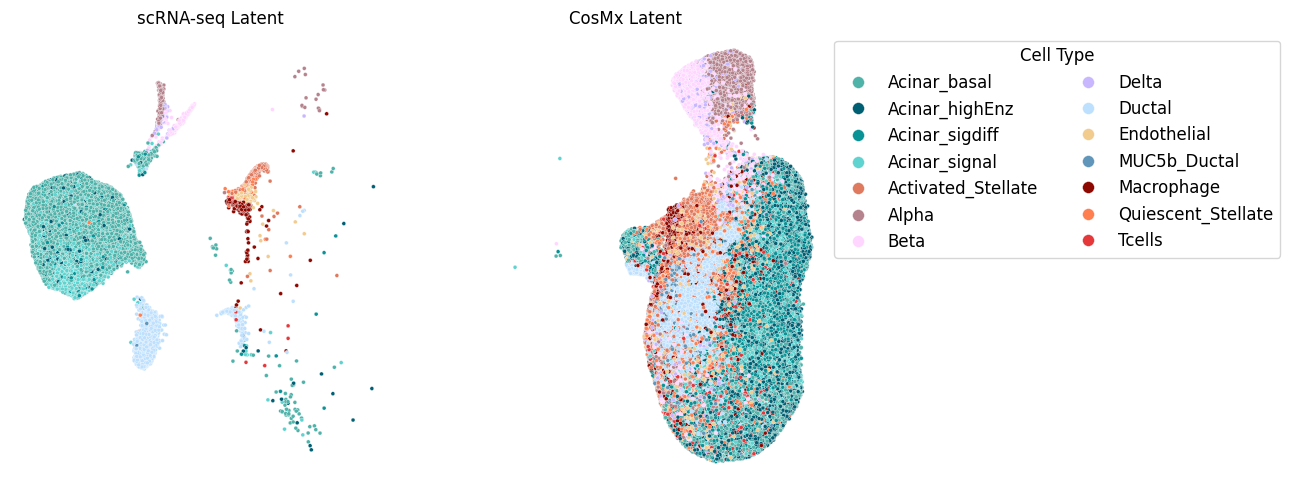

In [25]:
fig = plt.figure(figsize = (13,5))
plt.subplot(121)
sns.scatterplot(x = sc_data.obsm['latent_umap'][:, 0],
                y = sc_data.obsm['latent_umap'][:, 1], hue = sc_data.obs['cell_type'], s = 8, palette = cell_type_palette,
                legend = False)
plt.title("scRNA-seq Latent")
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.axis('off')

plt.subplot(122)
sns.scatterplot(x = st_data.obsm['latent_umap'][:, 0],
                y = st_data.obsm['latent_umap'][:, 1],  hue = st_data.obs['cell_type'], s = 8, palette = cell_type_palette, legend = True)


legend = plt.legend(title = 'Cell Type', prop={'size': 12}, fontsize = '12',  markerscale = 3, ncol = 2, bbox_to_anchor = (1, 1))#, loc = 'lower left')
plt.setp(legend.get_title(),fontsize='12')
plt.title("CosMx Latent")
plt.axis('off')
plt.tight_layout()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.show()

In [26]:
st_data, sc_data

(AnnData object with n_obs × n_vars = 108711 × 427
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max', 'niche_label', 'cell_type'
     uns: 'CellTypes_max_colors', 'cell_type_coarse_colors', 'design_matrix', 'neighbors', 'niche_label_colors', 'pca', 'spatial', 'spatial_neighbors', 'umap', 'COVET_genes'
     obsm: 'X_pca', 'X_umap', 'design_matrix', 'spatial', 'spatial_fov', 'envi_latent', 'COVET', 'COVET_SQRT', 'imputation', 'cell_type_niche',

### ENVI COVET analysis

In [38]:
st_data.uns['COVET_genes']

array(['APOD', 'BAG3', 'C11orf96', 'C1QA', 'C1QB', 'CASR', 'CCL2',
       'CD163', 'CHGA', 'COL18A1', 'COL1A1', 'COL1A2', 'COL3A1', 'COL4A1',
       'COL4A2', 'COL6A1', 'COL6A2', 'COL6A3', 'COL9A3', 'CPB1', 'CXCL2',
       'CXCL3', 'DCN', 'FCGBP', 'FGFR3', 'FN1', 'FOS', 'G6PC2', 'GCG',
       'GDF15', 'GPX3', 'HLA-DRB1', 'HSPA1A', 'IAPP', 'IGHA1', 'IGKC',
       'IL7R', 'INS', 'JUNB', 'KRT19', 'KRT7', 'LEFTY1', 'LYZ', 'MALAT1',
       'MEG3', 'MMP7', 'OLFM4', 'PRSS2', 'S100A6', 'S100A8', 'SCG5',
       'SERPINA3', 'SPARCL1', 'SPINK1', 'SPP1', 'SST', 'THBS1', 'TIMP1',
       'TM4SF1', 'TPSAB1', 'TPSB2', 'TTR', 'VWF', 'ZFP36'], dtype='<U8')

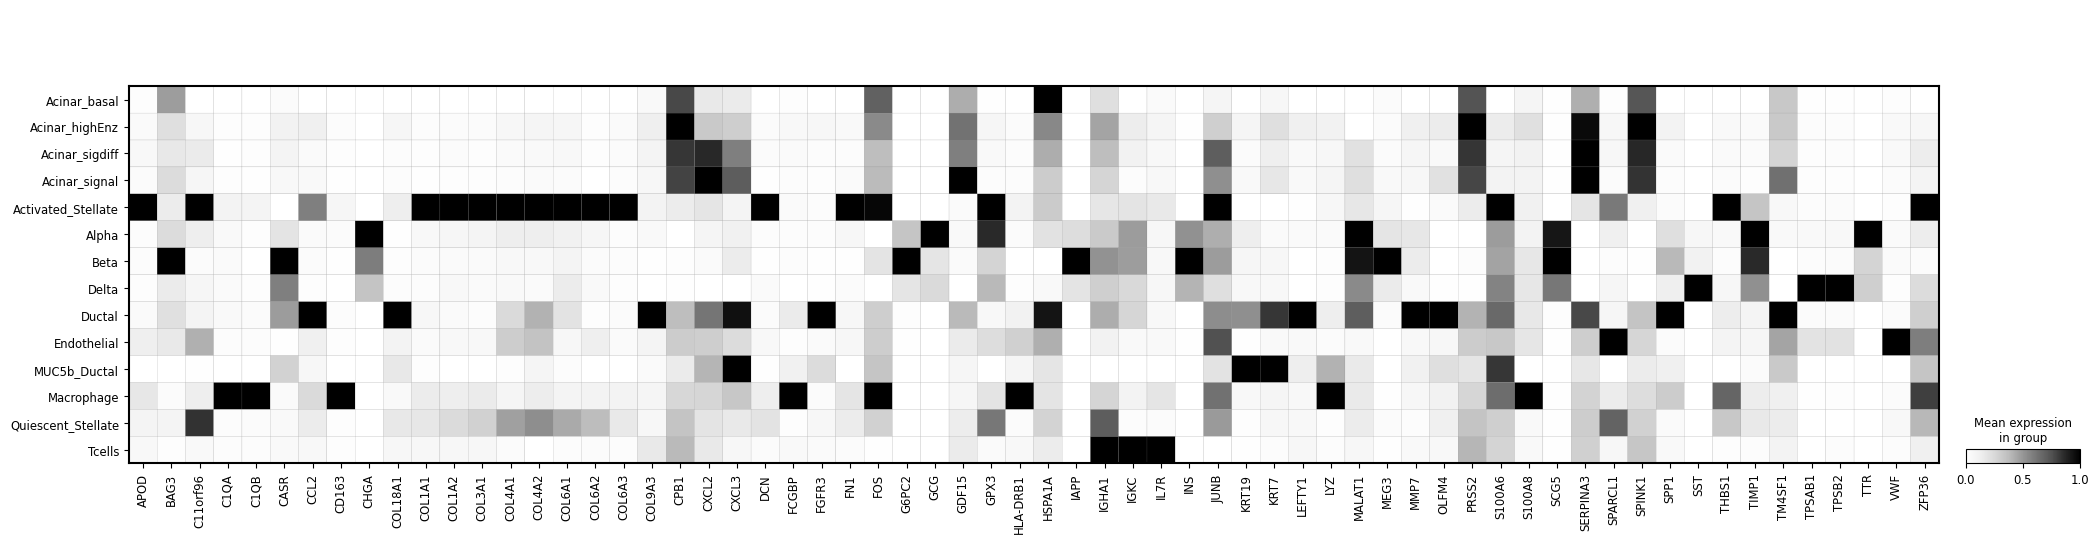

In [46]:
sc.pl.matrixplot(st_data, st_data.uns['COVET_genes'], groupby='cell_type',cmap='Greys',standard_scale='var', dendrogram=False)

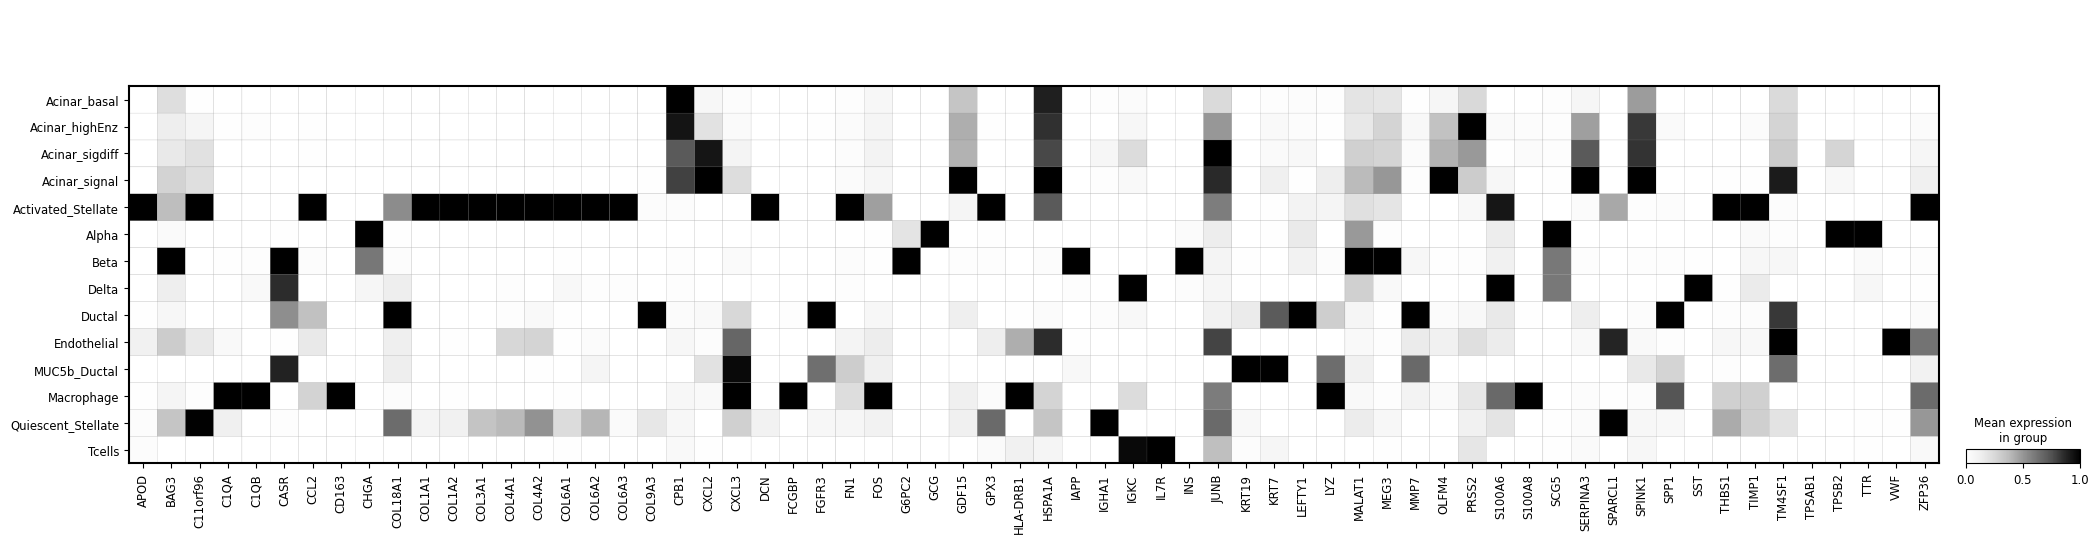

In [47]:
sc.pl.matrixplot(sc_data, st_data.uns['COVET_genes'], groupby='cell_type',cmap='Greys',standard_scale='var', dendrogram=False)

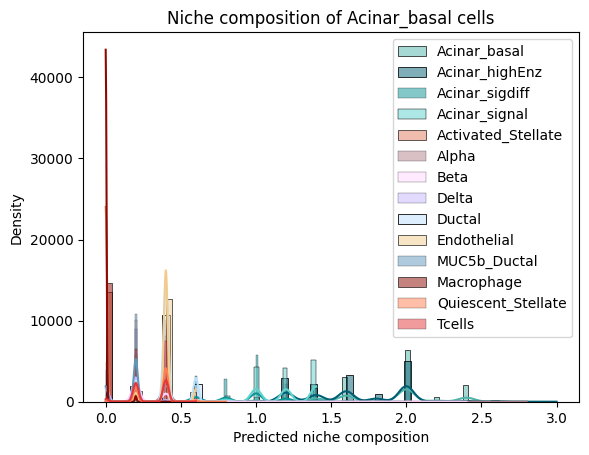

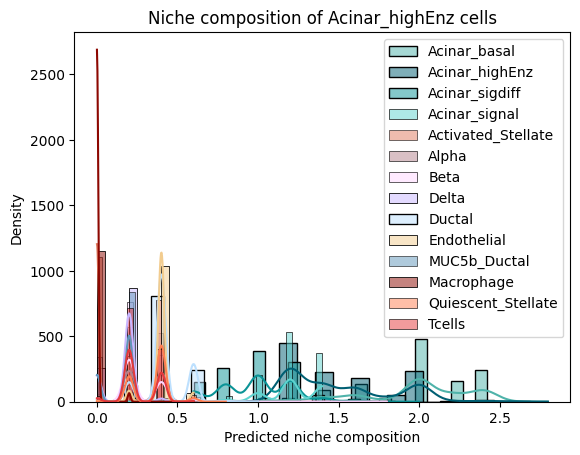

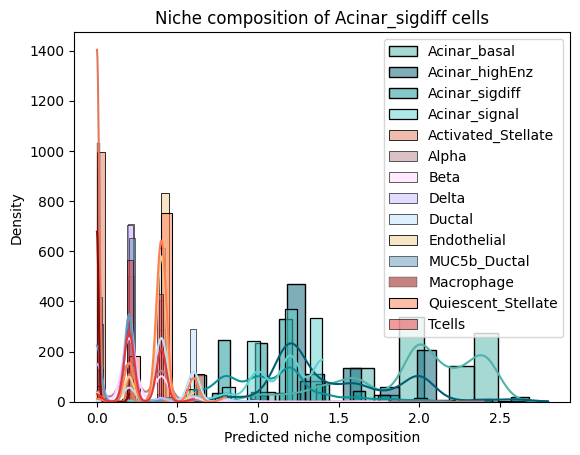

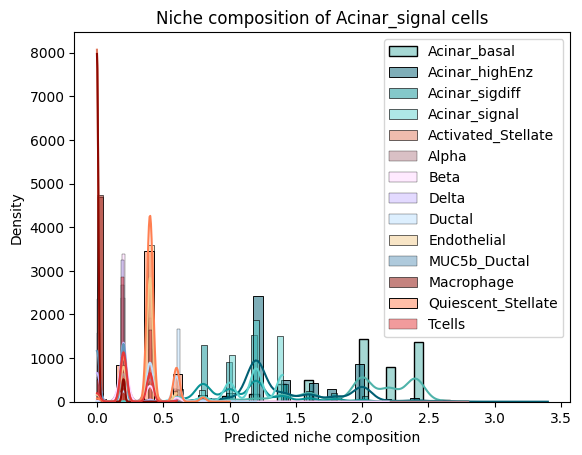

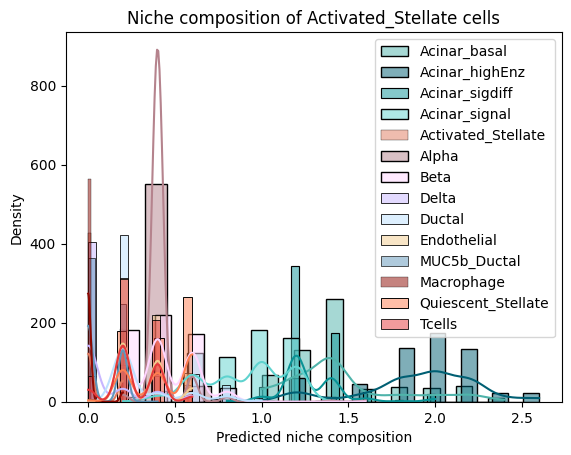

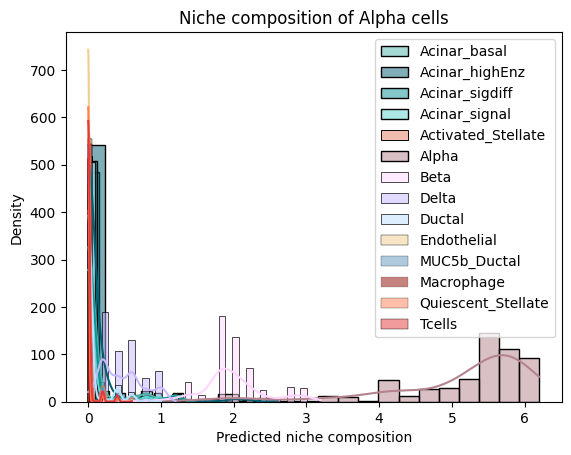

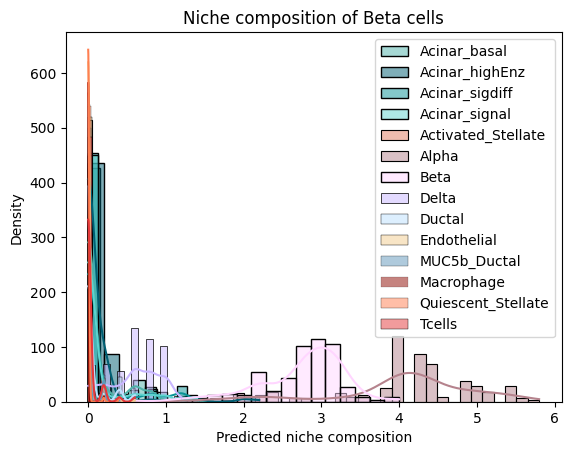

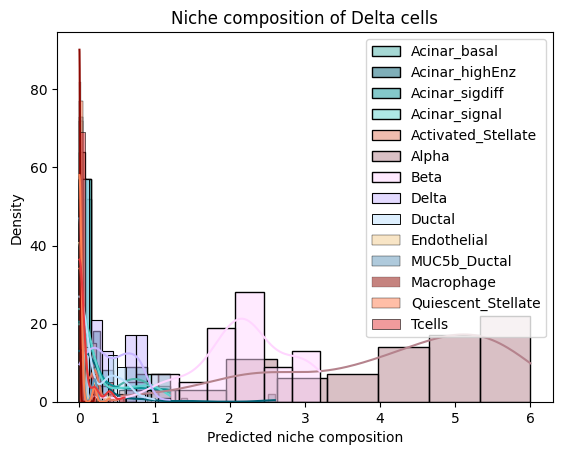

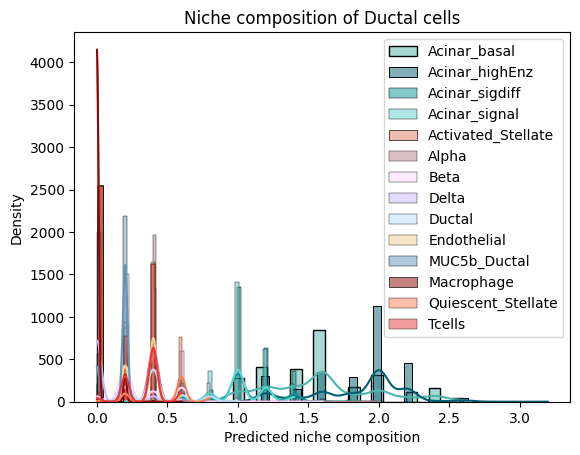

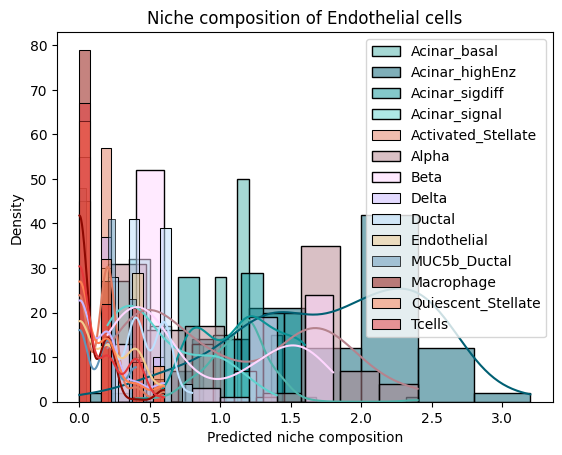

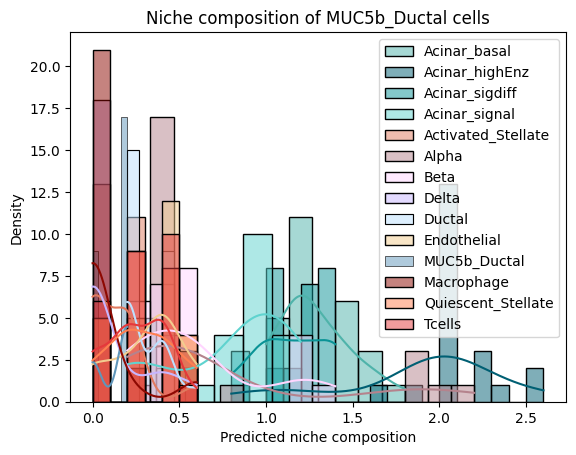

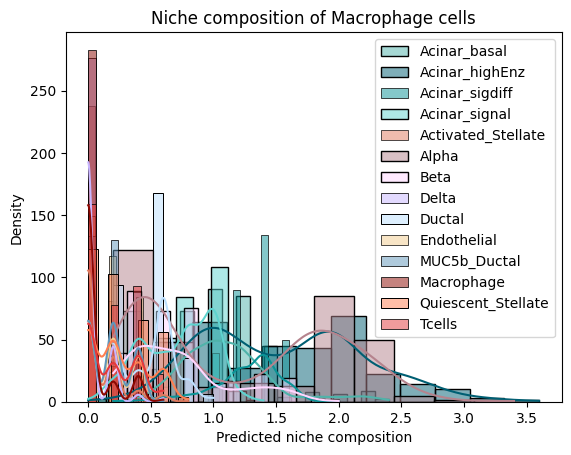

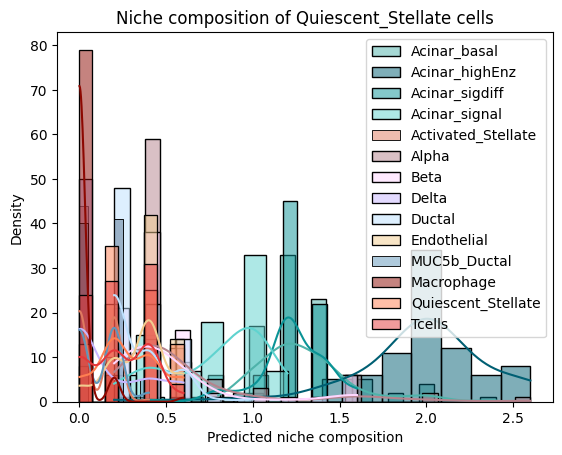

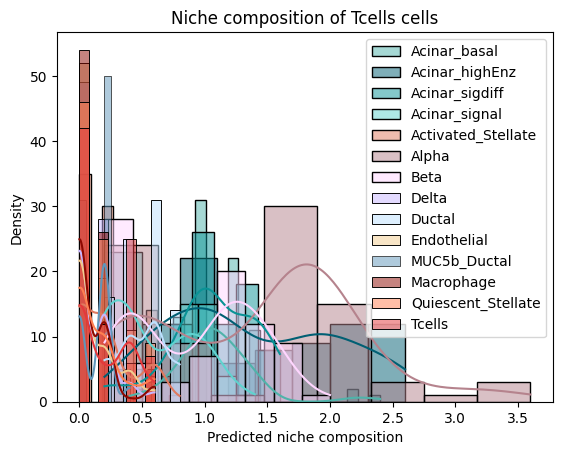

In [28]:
#plt.figure(figsize=(8, 6))

for i in sc_data.obs['cell_type'].cat.categories:
    sc_data_ct = sc_data[sc_data.obs['cell_type'] == i]
    
    for col in sc_data_ct.obsm['cell_type_niche'].columns:
        sns.histplot(sc_data_ct.obsm['cell_type_niche'][col], kde=True, color=cell_type_palette[col], label=col)
        #sns.hist(sc_data_ct.obsm['cell_type_niche'], kde=True, color=cell_type_palette, label=col)

    plt.xlabel('Predicted niche composition')
    plt.ylabel('Density')
    plt.title('Niche composition of '+i+' cells')
    plt.legend()
    plt.show()